#  🤗 Transformers

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://huggingface.co/docs/transformers/index
* https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.pipeline.task
* https://huggingface.co/docs/transformers/preprocessing
* https://huggingface.co/blog/getting-started-with-embeddings
* https://huggingface.co/sentence-transformers
* https://habr.com/ru/articles/704592/

## Задачи для совместного разбора

1\. Обсудите основные возможности и экосистему пакета 🤗 Transformers на примере задачи поиска ответа на вопрос в тексте.

In [ ]:
text = """The seminars on Deep Learning and Natural Language Processing were truly captivating,
providing a deep dive into the intricacies of these disciplines.
The wealth of knowledge and insights gained during the sessions was commendable.
However, it's disheartening to note the scarcity of homework assignments.
Anastasia, in particular, is quite concerned that the limited number of assignments might
fall short of even reaching 30. While the seminars were intellectually stimulating,
the desire for more hands-on practice through assignments remains strong,
as it is crucial for reinforcing the theoretical understanding acquired during the classes."""

In [ ]:
question1 = "What would be the ideal number of homework assignments for Anastasia"
question2 = "What are the shortcomings of the course?"

In [ ]:
import transformers

In [ ]:
from transformers import pipeline
question_answerer = pipeline(
    "question-answering",
    model='distilbert-base-uncased-distilled-squad'
    )

result = question_answerer(
    question=question1,
    context=text
    )

In [ ]:
result['answer']

'30'

In [ ]:
result = question_answerer(
    question=question2,
    context=text
    )

In [ ]:
result['answer']

'scarcity of homework assignments'

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering
import torch
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')

question, text = question1, text

inputs = tokenizer(question, text, return_tensors="pt")

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
answer_start_index = torch.argmax(outputs.start_logits)
answer_end_index = torch.argmax(outputs.end_logits)

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)

'30'

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Среди предобученных моделей найдите модель для перевода текста с русского языка на английский. Протестируйте данную модель на нескольких предложениях, используя `transformers.pipeline`. Выведите результаты работы в следующем виде:

```
sentence1_ru -> sentence1_en
sentence2_ru -> sentence2_en
```

Получите перевод для всех текстов из файла `RuBQ_2.0_test.json` и посчитайте BLEU-score.

- [x] Проверено на семинаре

In [2]:
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.8 MB/s eta 0:00:00


In [3]:
from transformers import FSMTForConditionalGeneration, FSMTTokenizer
mname = "facebook/wmt19-ru-en"
tokenizer = FSMTTokenizer.from_pretrained(mname)
model = FSMTForConditionalGeneration.from_pretrained(mname)

input = "Машинное обучение - это здорово, не так ли?"
input_ids = tokenizer.encode(input, return_tensors="pt")
outputs = model.generate(input_ids)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded) # Machine learning is great, isn't it?

tokenizer_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

vocab-src.json:   0%|          | 0.00/776k [00:00<?, ?B/s]

vocab-tgt.json:   0%|          | 0.00/639k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/396k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-ru-en and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

Machine learning is great, isn't it?


In [ ]:
translater = pipeline(
    "translation",
    model='facebook/wmt19-ru-en'
    )

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-ru-en and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input = ['что это?', 'как это?']
result = translater(
    input
    )

In [ ]:
res = list(zip(input, result))
for x, y in res:
  print(x, ' -> ', y['translation_text'])

что это?  ->  What is it?
как это?  ->  How is that?


In [ ]:
import json
import re

In [ ]:
X = []
y = []

with open('RuBQ_2.0_test.json', 'r') as f:
  for dct in json.load(f):
    X.append(re.sub(r'[^a-zа-я ]', '', dct['question_text'].lower()))
    y.append(re.sub(r'[^a-zа-я ]', '', dct['question_eng'].lower()))

len(X), len(y)

(580, 580)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batches = DataLoader(X, batch_size=64)

In [ ]:
results = []
for x in batches:
    result = translater(x)
    results.extend(result)

In [ ]:
results_ = [[res['translation_text']] for res in results]

In [ ]:
import nltk

candidate = results_
references = y

bleu_score = nltk.translate.bleu_score.corpus_bleu(candidate, references)
print(bleu_score)

0.734034844351371


<p class="task" id="2"></p>

2\. Загрузите данные из файла `reviews_polarity.csv`. Среди предобученных моделей найдите модель для классификации тональности русскоязычного текста (позитивный/негативный или позитивный/негативный/нейтральный). Протестируйте данную модель на нескольких предложениях, используя `transformers.pipeline`. Выведите результаты работы в следующем виде:

```
sentence1 -> class1
sentence2 -> class2
...
```

Получите прогноз для всех текстов из файла и посчитайте F1-score. Для ускорения работы модели вы можете перенести ее на GPU и использовать возможности pipeline для работы с батчами и генераторами.

- [ ] Проверено на семинаре

In [4]:
import pandas as pd

df = pd.read_csv('reviews_polarity.csv')
df.head()

,text,class
0,"Очень хорошо что открылась 5 ка, теперь не над...",1
1,"Тесно, вечная сутолока, между рядами трудно ра...",0
2,Магазин в пешей доступности. После ремонта и р...,1
3,Магазин хороший цены и скидки нормальные токо ...,1
4,Сложно найти в торговом центре. А магазин - норм),1


In [5]:
X = df['text'].tolist()

In [6]:
from transformers import pipeline
import torch as th

device = 'cuda' if th.cuda.is_available() else 'cpu'
model_name = "IlyaGusev/rubertconv_toxic_clf"
text_classfier = pipeline("text-classification",
                          model=model_name,
                          tokenizer=model_name,
                          framework="pt",
                          device=device)

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data.dataloader import DataLoader
batches = DataLoader(X, batch_size=64)

In [ ]:
from tqdm import tqdm
tonality = []
for x in tqdm(batches, total=len(batches)):
    tonality.extend(text_classfier(x))

100%|██████████| 598/598 [07:14<00:00,  1.38it/s]


In [ ]:
tonality_ = [ton['label'] for ton in tonality]

In [ ]:
import numpy as np

tonality_ = np.array(tonality_) #.map(lambda x: 1 if x == 'neutral' else 0, )
tonality_new = (tonality_ == 'neutral').astype(int)

In [ ]:
from sklearn.metrics import f1_score

f1_score(df['class'], tonality_new)

0.8813370310046809

<p class="task" id="3"></p>

3\. Создайте токенизатор, соответствующий модели из предыдущего задания, используя класс `AutoTokenizer`. Возьмите одно предложение из набора данных и токенизируйте его, используя созданный объект. Выведите на экран полученный результат. Выполните обратное преобразование: получите текст по набору токенов и выведите результат на экран.

Получите батч из 10 предложений и токенизируйте его. Продемонстрируйте возможности токенизатора для паддинга, обрезки, преобразования в тензоры.

- [ ] Проверено на семинаре

In [7]:
from transformers import AutoTokenizer

In [8]:
model_name = "IlyaGusev/rubertconv_toxic_clf"
tok = AutoTokenizer.from_pretrained(model_name)

In [9]:
sent = df['text'][0]
print(sent)
encoded = tok.encode(sent); encoded

Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом!


[101,
 3065,
 1643,
 825,
 33736,
 146,
 871,
 128,
 1661,
 802,
 1199,
 3194,
 5857,
 888,
 3504,
 106,
 102]

In [10]:
decoded = tok.decode(encoded); decoded

'[CLS] Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом! [SEP]'

In [ ]:
sentences = df['text'][:10].values.tolist()
res = tok(sentences, padding=True, truncation=True, return_tensors="pt")
res

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([[  101,  3065,  1643,   825, 33736,   146,   871,   128,  1661,   802,
          1199,  3194,  5857,   888,  3504,   106,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101, 10229,   793,   128, 48717,  7607,  4548,   813,   128,  1862,
         56278,  4703, 76683,   128, 53506,   132, 12213,  2497,   893,   132,
          4626,   802,  9458,   132,   102,     0,     0,     0,     0],
        [  101, 62127,   340,  6836,   371, 36716,   132,  2525, 17375,   322,
         22263,  2774,  5467,  1554,   322, 15530,  1229,   132, 67740,  2892,
         17311, 63879,   909,   322, 94994,   132,   102,     0,     0],
        [  101, 62127,  4445,  3877,   322, 28892,  9639, 77737,   888,  1210,
           352,  1312,  2587,  1980, 42170, 21867,   802,   352,  1437,   999,
          1928,   801, 40458,  1583,   102,     0,     0,     0,     0],
        [  101, 26093,  2692,   340, 51754,  6339,   132,   44

<p class="task" id="4"></p>

4\. Решите задачу 2, создав объект токенизатора (`AutoTokenizer`) и модель (`AutoModelForSequenceClassification`).

- [ ] Проверено на семинаре

In [11]:
from transformers import AutoModelForSequenceClassification
mname = "IlyaGusev/rubertconv_toxic_clf"
model = AutoModelForSequenceClassification.from_pretrained(mname)
model = model.to(device='cuda')
tokenizer = AutoTokenizer.from_pretrained(mname, padding=True, truncation=True, return_tensors="pt")

In [ ]:
import torch as th

In [14]:
input = df['text']

In [ ]:
from torch.utils.data.dataloader import DataLoader
batches = DataLoader(input, batch_size=16)

In [ ]:
outs = []
for batch in batches:
    tokenized_batch = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
    out = model(tokenized_batch['input_ids'].to(device='cuda'), tokenized_batch['attention_mask'].to(device='cuda'))
    outs.extend(out.logits.argmax(dim=1).to(device='cpu'))

In [ ]:
from sklearn.metrics import f1_score

f1_score(df['class'], outs)

0.002383869152070986

<p class="task" id="5"></p>

5\. Используя пакет `sentence-transformers`, загрузите модель `distiluse-base-multilingual-cased-v1`. Используя эту модель, получите эмбеддинги всех предложений из набора данных. Во время генерации эмбеддингов используйте батчи размера 64 и отобразите процесс получения эмбеддингов в виде полосы загрузки.

Уменьшите размерность эмбеддингов при помощи PCA и отобразите точки в двумерном пространстве, раскрасив их в цвет соответствующего им класса.

- [ ] Проверено на семинаре

In [12]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=7e631629f39e0b10657970d1b5702dd8b6957d8bfe69079cf5c6224b85d486d4
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

In [15]:
from torch.utils.data.dataloader import DataLoader
batches = DataLoader(df['text'], batch_size=64)

In [22]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device='cuda')

emb = model.encode(
    df['text'],
    batch_size=64,
    device='cuda',
    convert_to_tensor=True,
    show_progress_bar=True
)

pca = PCA(n_components=2)
emb_pca = pca.fit_transform(emb.cpu())

Batches:   0%|          | 0/598 [00:00<?, ?it/s]

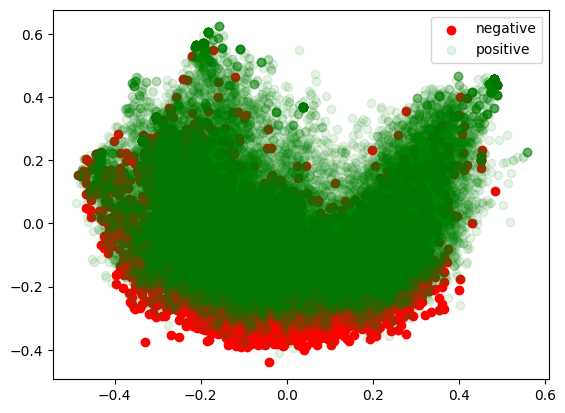

In [24]:
import numpy as np
import matplotlib.pyplot as plt

classes = df['class'].values.reshape(-1, 1)
res = np.concatenate([emb_pca, classes], axis=1)

negative = res[res[:, 2] == 0][:, :2]
positive = res[res[:, 2] == 1][:, :2]

plt.scatter(negative[:, 0], negative[:, 1], color='red', label='negative')
plt.scatter(positive[:, 0], positive[:, 1], color='green', alpha=0.1, label='positive')
plt.legend();

## Обратная связь
- [ ] Хочу получить обратную связь по решению